In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

Question1 

To generate a random 2 d array from normal distribution numpy has a function numpy.random.randn
uses mean = 0 and standard deviation 1

Reference : https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html

Concept : 
In the context of linear regression, correlations refer to the degree to which independent variables are related to each other. Each column of random matrix is a feature independenlty sampled from normal distribution, by changing S we determine the degree of relation or correlations between these features 
S = I implies no correlations
Source : chat-gpt

coding structure -> self

In [56]:
def generate_input_data(n, S, M):
    m = M ## arbitary chosen no. of columns/features
    ##generate random matrix of size NXM
    random_matrix = np.random.randn(n,m)
    ##GENERATE INPUT DATA MATRIX using np.dot for matrix multiplication
    X = np.dot(random_matrix,S)
    ## X HAS no. of columns equal to desired outputs and each rows corresponds to sample
    return X
   
    

Q2 To add zero mean gaussian noise I used numpy.random.normal as it allows specifying sigma and mean unlike randn which uses default values ref: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html 
dimensional mismatch (input N X D and noise is D+1 X 1) tacked by excluding 1st element from noise matrix
Concept : simulate real world scenarios target set itself not ideal maybe measurement noise or other gaussian noice to be added

In [4]:
def generate_target_matrix(X, w, sigma):
    ##check dimenstional mismatch   X = N X D while w = row vector of size D+1
    is_same = X.shape[1] == w.shape[0]
    if(not is_same):
        ## if mismatch reduce exclude 1st element
        w = w[1 :]  # excluded 0TH
        bias = w[0]
    else:
        bias = 0
    ##weighted input
    X_wt = np.dot(X,w)
    ##ADD BIAS
    X_biased = X_wt + bias
    ##add gaussian noise of variance sigma
    noise = np.random.normal(loc=0.0, scale=sigma, size= X_biased.shape)
    ##final target set
    t = X_biased + noise
    return t
    
    
    
    

Q3 concept: pseudo inverse tackles the problem of computing inverse for least square problems when 
true inverse might not be defined i.e either X has depended variables or isn't sqauare matrix
method used to do so is single value decomposition which is what is used by analytical solver of numpy.linalg
package  ref: https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html 

Ideation : to analyse behavior wrt to scale and to plot log-log plots  vary the input size of N
in powers of 10s   source : self

Method to estimate time : use time library and mark time at the beginning and at end of computation 
and time duration would be given by start-end source : chat gpt

In [6]:
def time_computation(N,D =10):
    duration = []
    for n in N:
        ##use random matrix of size N to check computation
        t = np.random.randn(n)
        ## matrix having same size as that of input matrix
        X = np.random.randn(n,D)
        ##mark start time
        start = time.time()
        ##compute inv using np
        np.linalg.pinv(X) @ t
        ##mark end time
        end = time.time()
        ##compute duration of computation
        d = end - start
        ## to make a plot i need a list of duration against different values of N
        duration.append(d)
    return duration


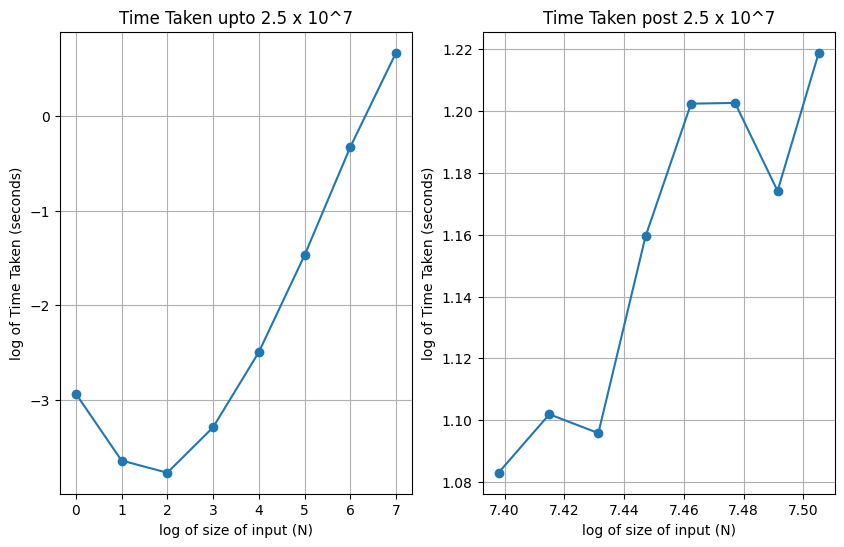

In [52]:
## analyse 
##genearate N for analysis
N = [10**n for n in range(8)]  ##10 data points
##generate computation time
T = time_computation(N)
##plot logN vs logT
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(np.log10(N), np.log10(T) , marker='o')
plt.title('Time Taken upto 2.5 x 10^7')
plt.xlabel('log of size of input (N)')
plt.ylabel('log of Time Taken (seconds)')
plt.grid(True)
##kernel crashed for N = 8 onwards so seperately printing 2.5 x 10^7(hit and trial) onward for analysis
N_high = [(25+n)* 10**6 for n in range(8)]
T_high = time_computation(N_high)
plt.subplot(1,2,2)
plt.plot(np.log10(N_high), np.log10(T_high) , marker='o')
plt.title('Time Taken post 2.5 x 10^7')
plt.xlabel('log of size of input (N)')
plt.ylabel('log of Time Taken (seconds)')
plt.grid(True)
#plt.show()


Observation :  for N upto 10^7  the computational time was within acceptable limits , the time taken was not even substantial until 10^7 even which was not more than 10s
However for even 3.5 time 10^7 compututional time had a sudden spike which caused the kernal to crash, this can be seen in second graph where slope of even log scale is tending to very high values and after last reading i.e 3.2 x 10^6 kernel crashed 

Reasoning : the method used by pinv of numpy package is SVD which involves computing three matrix for every matrix A of which inverse has to be computed and performing matrix multiplication since size of these matrices are NXD , NXN and DXD , no .of computations increases propotionally to N
Beyond a certain threshold, the system may run out of memory, leading to increased computational time or even a crash.
ADDITIONAL INPUT FROM CHAT GPT : total complexity of SVD is O(N.D^2)  this is due to combined effect of matrix mutliplication computation, transpose operations and inverse of singular values



Q4  rmse is root of mean of  square of deviation of predicted and target values
To normalise rmse we divide it by the range of target values so that it gets confined in range 0 to 1
source of normalisation echnique = chat gpt


In [7]:
def nrmse(input, weights,target):
    ##prediction
    prediction = np.dot(input,weights)
    ##calculate rmse
    rmse = np.sqrt(np.mean((target-prediction)**2))
    ##calculate range(
    ran = np.max(target) - np.min(target)
    ##nmrse
    nmrse = rmse/ran
    return nmrse

Q5 : Ref : https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf (pg 4)
notion of stochastic gradient descent/ batch gradient descent and how to formulate
wj = wi(initial gues) + learning_rate(gradient wrt wj) in algorithmic form


In [8]:
def compute_grad(input,weights,target):
    ##compute prediction
    pred = np.dot(input,weights)   ##assuming input is N X D and weigts D X 1
    ##error  N X 1 matrix  error for each sample size
    error = pred - target
    ##mse 2 x error ^2 / no. of samples
    MSE = np.mean(np.square(target - pred))
    ## no. of samples
    N = input.shape[0]    
    ## cal grad wrt weights
    ##basically model 2 x (pred_i - target_i)input_j/Number of samples in matrix format
    grad = 2 * np.dot(input.T,error) / N
    return grad 
    

Q6 : reference : https://math.stackexchange.com/questions/883016/gradient-of-2-norm-squared
To be clear  The following fuction calculates the gradient of square of L2 norm as ultimately L2 regularisation employs  square L2 norm according to https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261. Now tht we have mathematical formulation that grad of L2 norm (simply cummulative sum of squares of weights) is simply 2 times weights , code is trivial

In [9]:
def grad_L2(weights):
    ## weights is D x 1 array
    grad = 2*weights  ### derivation in first link
    return grad
    

Q7: We know that L1 norm is simply sum of absolute value of weights
Clearly this ain't differentiable , so to get around this problem , a thread from stackexchange suggested " This norm is not differentiable with respect to a coordinate where that coordinate is zero. Elsewhere, the partial derivatives are just constants, ±1 depending on the quadrant.

Additional input from gpt : subgradient methods are often used to handle the gradient of the L1 norm. The subgradient of the L1 norm at a point where the vector is not zero is simply the sign of each element of the vector. At points where the vector is zero, any value between -1 and 1 is a valid subgradient.

So I just coded above notions out as follows

In [10]:
def grad_L1(weights):
    ##grad is simply signum of ith element
    grad = np.sign(weights)
    ##assign random value where weights is 0 
    grad[weights == 0] = np.random.uniform(-1, 1, np.sum(weights == 0)) ##taken directly from chat gpt
    ##breakdown of directly copied line
    #grad[w == 0] selects all elements in grad array where w == 0
    # np.sum(w==0) total elements having value 0 
    #np.random.uniform(-1, 1, np.sum(w == 0)) basically generates array of random values from
    #uniform distribution of size equals to np. of 0 elements
    return grad
    

Q8: Ideation : we have functions for calculating grad of all 3 terms independently
so just have to make a commulative loss function with regularization terms added, for stopping criteria
I could only think of epsilon method , the cost function has converged or assumed minimum value when differnce between consecutive costs less than epsilon

Chat gpt help: make a list appending cost function values computed after every iteration and stopping
criteria will simply be "np.abs(losses[-1] - losses[-2]) < tolerance:"


In [11]:
def Grad_Reg(input, weights, target, alpha1, alpha2, iterations, learningRate):
    costValues = []
    ##lets make cost function  few terms directly copied from prev ans
    for i in range(iterations):  ## try to keep iteratations large so that converge well before
        pred = np.dot(input,weights)   ##assuming input is N X D and weigts D X 1
        ## MSE
        MSE = np.mean((target - pred)**2)
        ##L1 regularization
        lambda1 = alpha1 
        L1 = lambda1 * np.sum(np.abs(weights)) ## simply coded defination
        ###L2 regularization
        lambda2= alpha2 
        L2 = lambda2 * np.sum(np.square(weights))
        ##NET COST
        cost = MSE + L1 + L2
        #3store cost
        costValues.append(cost)
        ## net grad  directly use prev functions
        gradient = compute_grad(input, weights, target) + grad_L1(weights) + grad_L2(weights)
        ##update weight acc to basic gradient descent
        r= learningRate ## to be tuned
        weights = weights - r * gradient
        
        ##stopping criteria  credits gpt
        epsilon = 0.000001  #3 to be tuned
        if i > 0 and np.abs(costValues[-1] - costValues[-2]) < epsilon:
            print(f"Converged after {i} iterations.")
            break
    return weights
        
    
    

In [58]:
## test gradient descent related functions


Q9: try to test all exsisting functions in the analysis and make observations on results
THe algorithm is explained well in question and I just coded out independent steps

splitting the data : my thought decide percentage amount to split data into training and validation parts Chat Gpt improved upon this by spitting out this piece of code train_size = "int(train_ratio * num_samples)
    indices = np.random.permutation(num_samples)
    train_indices, val_indices = indices[:train_size], indices[train_size:]" which is self explanatory and obvious but I had no idea of exsistence of np.random.permutation so I will be using it as such

assuming G is generator matrix same as S in part 1

coding practise: have to conduct experiment by keep on changing params so better to define a function
to conduct experiment and return avg values  so that i can passs various parameters again and see effect before settling on final values



In [82]:
def analysis(sigmaValues, N, alpha1, alpha2, iterations, learningRate,D, NumRuns=5):
    ##analysis => plots => storing values
    avg_nmrse = [] #3 list to store nmrse
    ## generate data
    M = 5 ## arbitary
    D = 2 ## no of features
    G = np.eye(M,D)  ##identity generator matrix of sample size
    ##input matrix
    X = generate_input_data(N,G,M)
    
    ## weights initialized random
    w = np.random.randn(D, 1)
    
    for sigma in sigmaValues: #iterate over sigmas  ##i.efor i run
        nmrseValues = [] #3 stores nmrse values for each sigms
        for i in range(NumRuns):  ## 5 runs for each sigma
            ##target matrix
            t = generate_target_matrix(X, w , sigma)
            
            ##split data  partial credits gpt
            tRatio = 0.8 ##asked chat gpt for optimal value owing to bias - variance tradeoff
            train_size = int(tRatio * N) ##size of training data
            indices = np.random.permutation(N) ## random indices for training data  better training
            ##split indices in training and validation sets
            train_indices, val_indices = indices[:train_size], indices[train_size:]
            ## split input
            X_train, X_val = X[train_indices], X[val_indices]
            ##split target values
            t_train, t_val = t[train_indices], t[val_indices]
            
            ##training using gradient descent 
            ## adding L1 and L2 regularization as well so that can use same function for Q10
            w = Grad_Reg(X_train, w, t_train, alpha1, alpha2, iterations, learningRate) ##returns optimized weights
            ##now we have weights test these on valditatin data to which model would be exposed for first time
            ##i.e nmrse should be min 
            nmrse = nrmse(X_val, w, t_val)
            ##add nmrse after each run to list so that we can avg it out
            nmrseValues.append(nmrse)
        ##average out nmrse
        avg = np.mean(nmrseValues)
        ##add avg values tto list
        avg_nmrse.append(avg)
    ##we have list of avgValues for each sigma
    return avg_nmrse      
        
    

Converged after 121 iterations.
Converged after 101 iterations.
Converged after 554 iterations.
Converged after 42 iterations.
Converged after 284 iterations.
Converged after 42 iterations.
Converged after 50 iterations.
Converged after 389 iterations.
Converged after 814 iterations.
Converged after 43 iterations.
Converged after 173 iterations.
Converged after 109 iterations.
Converged after 26 iterations.
Converged after 157 iterations.
Converged after 43 iterations.
Converged after 825 iterations.


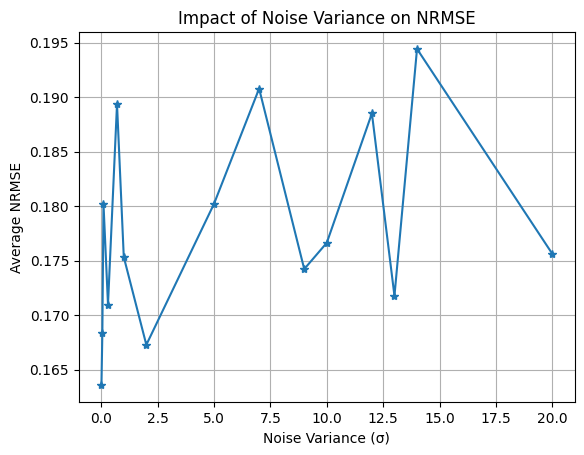

In [92]:
##  Q9 analysis
##sent sigma values
sigmaValues = [0.01,0.05,0.1,0.3 ,0.7, 1.0, 2.0, 5.0, 7, 9 ,10,12,13,14,20]  # Noise variance
##sample size
N = 1000
D = 2  ## no of features
## learning rate  (asked chat gpt what should it be can always improvise)
learning_rate = 0.01
## no of iterations
Iterations = 1000
##Lamdas for regularization
lambda1 = 0.1 ##asked gpt for initial values
lambda2 = 0.01
# perform analysis
avgValues = analysis(sigmaValues, N,lambda1,lambda2, Iterations, learning_rate, D)

# Plot average NRMSE versus sigma
plt.plot(sigmaValues, avgValues, marker='*')
plt.xlabel('Noise Variance (σ)')
plt.ylabel('Average NRMSE')
plt.title('Impact of Noise Variance on NRMSE')
plt.grid(True)
plt.show()

Q9 comments on results :  on increasing variance which can be seen as inherent noice in target region avg nmrse is increases arbitarily in low variance and high variance region 1.e the prediction obtained by training weights using gradient descent is much more farther to validation data , with a maximum in middle

This is explained by bias variance tradeoff

low noise(around 0.1 -1 region) => overfitting , our model learns training data way to well so that when presented with new data it gives more error

high noise above 10 => underfitting the training data itself becomes so random that our model itself has low accuracy so doesn't work well

However results above are more or less random( different each time) and to some extend obeys above notions but not in absolute sense  ig can be improved by changing regularization params and learning rate

Q10  using same analysis function created for linear regression
To examine the impact I iterate computation of weights for 5 N's and for each N I will iterate over 5 lambda2  , credits to gpt on how to analyse their impacts efficiently , basically I ll plot 5 subplots each corresponding to a given N and with each N variation with lambdas

In [99]:
## just change iteration parameters in same function as Q9
## not going into avg nmrse stuff running only for 1 iteration
def analysisRegularization(sigma, Nvalues, alpha1Values, alpha2Values, iterations, learningRate,D, numRuns =5):
    ##analysis => plots => storing values
    avgnmrseValues = [] ## list of list to store nmrse for each N lambda 2 pair
    ## generate data
    M = 5 ## arbitary
    D = 2 ## no of features    
    ## weights initialized random
    w = np.random.randn(D, 1)
    
    for N in NValues: #iterate over sigmas  ##i.efor i run
        avgnmrseN = [] #3 stores nmrse at given N averaged out over 5 run
        for alpha2 in (alpha2Values):  ## iterate over alpha
            nmrseValues = [] 
            for i in range(numRuns): ## 5 runs for each lambda N pair
                G = np.eye(M,D)  ##identity generator matrix of sample size
                ##input matrix
                X = generate_input_data(N,G, M)
        
                ##target matrix
                t = generate_target_matrix(X, w , sigma)
                
                ##split data  partial credits gpt
                tRatio = 0.8 ##asked chat gpt for optimal value owing to bias - variance tradeoff
                train_size = int(tRatio * N) ##size of training data
                indices = np.random.permutation(N) ## random indices for training data  better training
                ##split indices in training and validation sets
                train_indices, val_indices = indices[:train_size], indices[train_size:]
                ## split input
                X_train, X_val = X[train_indices], X[val_indices]
                ##split target values
                t_train, t_val = t[train_indices], t[val_indices]
                
                ##training using gradient descent 
                ##keep alpha1 fixed 
                alpha1 = alpha1Values[0]
                w = Grad_Reg(X_train, w, t_train, alpha1, alpha2, iterations, learningRate) ##returns optimized weights
                ##now we have weights test these on valditatin data to which model would be exposed for first time
                ##i.e nmrse should be min 
                nmrse = nrmse(X_val, w, t_val)
                ##add nmrse after each run to list so that we can avg it out
                nmrseValues.append(nmrse)
            ##average out for given alpha at given N
            avgnmrse = np.mean(nmrseValues)
            avgnmrseN.append(avgnmrse)  ## at a given N variation with lambda 2
        ##make a array where ith row corresponds to nmrse for all alphas at ith N
        avgnmrseValues.append(avgnmrseN)
        ##  5 x 5 array
    ##we have list of avgValues for each sigma
    return avgnmrseValues    
        
    

Converged after 421 iterations.
Converged after 263 iterations.
Converged after 381 iterations.
Converged after 417 iterations.
Converged after 352 iterations.
Converged after 310 iterations.
Converged after 258 iterations.
Converged after 406 iterations.
Converged after 291 iterations.
Converged after 294 iterations.
Converged after 413 iterations.
Converged after 462 iterations.
Converged after 401 iterations.
Converged after 426 iterations.
Converged after 509 iterations.
Converged after 587 iterations.
Converged after 521 iterations.
Converged after 583 iterations.
Converged after 459 iterations.
Converged after 340 iterations.
Converged after 235 iterations.
Converged after 228 iterations.
Converged after 273 iterations.
Converged after 305 iterations.
Converged after 122 iterations.
Converged after 254 iterations.
Converged after 255 iterations.
Converged after 213 iterations.
Converged after 244 iterations.
Converged after 230 iterations.
Converged after 367 iterations.
Converge

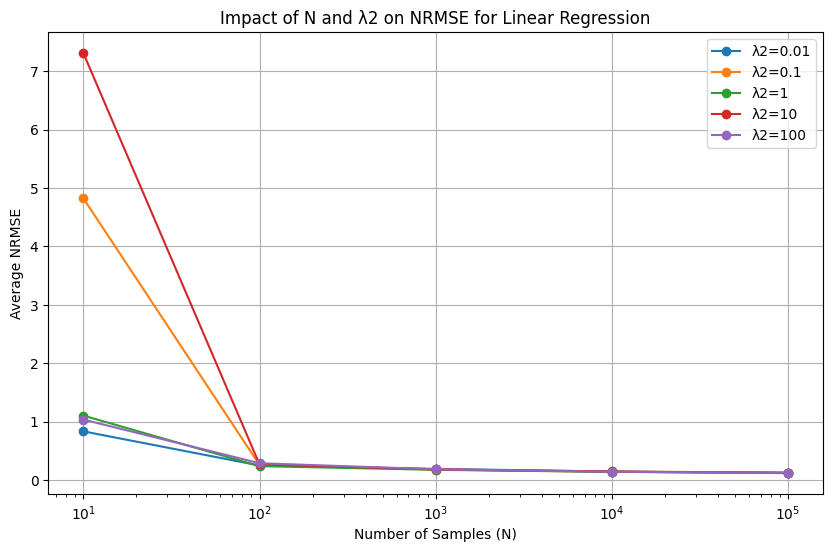

In [102]:
## Q 10 analysis
##sent different sample size
NValues = [10**n for n in range(1,6)]  # Noise variance
##optimal variance from 9th part
sigma  = 9
D = 2  ## no of features
## learning rate  (asked chat gpt what should it be can always improvise)
learning_rate = 0.01
## no of iterations
Iterations = 1000
##Lamdas for regularization
lambda1Values = [0.1] ##arbitary effect not analysedd
lambda2Values = [0.01, 0.1 , 1, 10 ,100] 
# perform analysis
Values = analysisRegularization(sigma, N,lambda1Values,lambda2Values, Iterations, learning_rate, D)

# credit to this plotting idea goes to gemini 
# basically iterate through every row of Values matrix each row corresponds to distribution
## -- against alpha2's for given N
plt.figure(figsize=(10, 6))
for i in range(len(lambda2Values)):
    plt.plot(NValues, [row[i] for row in Values], marker='o', label=f'λ2={lambda2Values[i]}') ## asked gemini
plt.xlabel('Number of Samples (N)')
plt.ylabel('Average NRMSE')
plt.title('Impact of N and λ2 on NRMSE for Linear Regression')
plt.legend()
plt.grid(True)
## using log scale
plt.xscale('log')
plt.show()

Observations : at high sampe size the L2 regularization strength doesn't has signifucant impact of nrmse value
at low sample size though for either very low lambda2 or very high lambda 2 error attains minimal value ,it shoots abruptly at intermediate values 0.1 and 10  trend is not uniform

Inference : lambda2 basically controls to what degree we wish to penalize weights 
at large sample size dataset is rich in information so error converges anyways as we can minimize loss function with or without high orders of weight so degree of penalizing doesn't cause much effect

at high Lambda => high weights penalized => when dat not sufficient data ,ight suffer from underfitting
at low lambda => weights can cause overfitting i.e high validation error because model became way too accurate wrt training set that has high bias

optimal point should be somewhere in middle but as seen the results are contradictory indicating inaccuracies of model which has to be more appropriately tuned

Q11  concept : variable elimination is same as L1 regularization or lasso regression (penalizing L1 norm of weights along with mean sqaure error)
As the regularization strength or lambda1 increases, more coefficients are driven to exactly zero, effectively eliminating certain variables from the model. hence the term variable elimination

For examining its impact on weights we can use GradReg function for calculating weights and see their variation with 1/lambda1


Converged after 288 iterations.


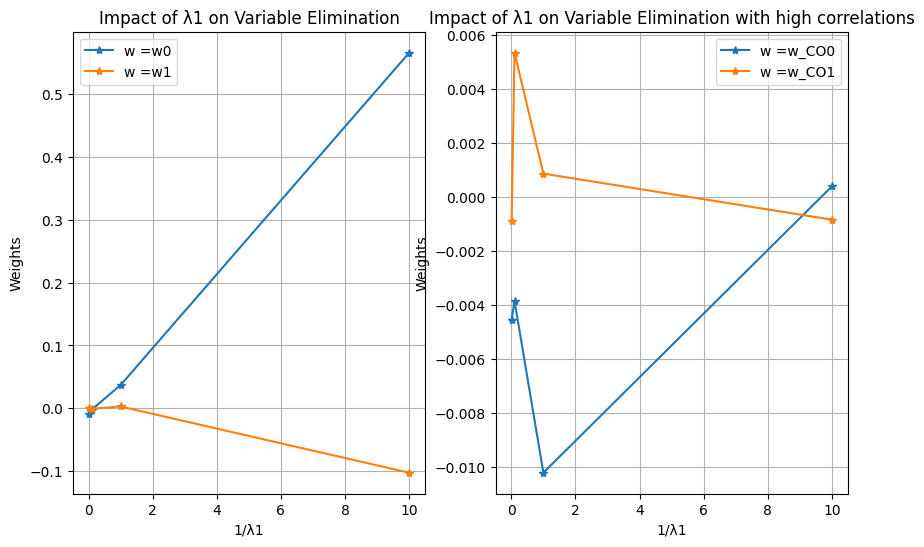

In [53]:
##part 1 Q 11
## 1 by lambda 1
lambda_reciprocal = []
sigma = 2  # optimal Noise variance from q9
##sample size
N = 10000 ## optimal sample size q1
D = 2  ## no of features ## single data matrix
M = 2
is_correlated = False  ## ease of analysis to slect correlated or uncorrelated
##input matrix without correlations
G = np.eye(M,D)  ##identity generator matrix of sample size
## introduce correlations
S = np.array([[1, 0.8],[0.8,1]])  ## introduce correlations  0.8 instead of 0  so high correlations
##input matrix
X = generate_input_data(N,G,M)
X_Co = generate_input_data(N,S,M)
## weights initialized random
w = np.random.randn(D, 1)
##for correlated
w_co = np.random.randn(D, 1)
## learning rate  (asked chat gpt what should it be can always improvise)
learningRate = 0.01
## no of iterations
Iterations = 1000
##Lamdas for regularization
lambda1Values = [0.1 ,1 , 10, 100] ##asked gpt for initial values
lambda2 = 0.01
##array to store weights
weights = np.zeros((D,len(lambda1Values)))
weightsCo = np.zeros((D,len(lambda1Values)))

for k,lambda1 in enumerate(lambda1Values):
    ##target matrix
    t = generate_target_matrix(X, w , sigma)
    ##for correlated input
    w_co = Grad_Reg(X_Co, w, t, lambda1, lambda2, Iterations, learningRate)
    w = Grad_Reg(X, w, t, lambda1, lambda2, Iterations, learningRate)
    ## w = D x1 array extract element  ##stores w in weights
    weights[:,k] = w.flatten() ## each colum stores consecutive iterations
    weightsCo[:,k] = w_co.flatten()
    ##simultaneousily compue i/lambda
    lambda_reciprocal.append(1/lambda1)
#print(len(weights))
# Plot weights versus 1/λ1
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i in range(w.shape[0]):
    plt.plot(lambda_reciprocal, weights[i,:], marker='*', label=f'w =w{i}') ## asked gemini
plt.xlabel('1/λ1')
plt.ylabel('Weights')
plt.title('Impact of λ1 on Variable Elimination')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
for i in range(w_co.shape[0]):
    plt.plot(lambda_reciprocal, weightsCo[i,:], marker='*', label=f'w =w_CO{i}') ## asked gemini
plt.xlabel('1/λ1')
plt.ylabel('Weights')
plt.title('Impact of λ1 on Variable Elimination with high correlations')
plt.grid(True)
plt.legend()
plt.show()

Analysis : Effect of Lambda 1
high 1/lambda => low pentalty of weights according to lasso regularization => less constrained weights
so weights can assume high values this trend is seen in first weight cofficient
vice versa true for low weight oefficient

Obs : second weight cofficient working exactly opposity to this trend

effect of high correlations between features
obs : Yes, the weights reduced substantially on introducing strong correlationst

chat gpt explanation :"When features are strongly correlated, the model faces a trade-off between selecting multiple correlated features with small coefficients or selecting one representative feature with a larger coefficient.it tends to favor solutions with fewer non-zero coefficients to achieve sparsity." which explain smaller coefficients
Theory: Lasso regression tends to select one feature from each group of correlated features while setting the coefficients of the others to zero.
This grouping effect means that correlated features tend to have similar coefficients.

Q12 elastic net combines the penalties of both Lasso and Ridge, allowing for variable selection (sparsity) like Lasso while also handling multicollinearity (correlated features) better like Ridge
in other words it introduces ratio control to determine what extend of pentalities of weight should be in L1 norm form and L2 norm format, 

To demonstrate grouping effect we first modify grad compution to introduce ratio control
and plotting weights against degree of correlation and note observations

ref : https://machinelearningcompass.com/machine_learning_models/elastic_net_regression/

In [58]:
def elastic_net_gradient(input, weights, target, alpha,r, iterations, learningRate):
    costValues = []
    ##lets make cost function  few terms directly copied from prev ans
    for i in range(iterations):  ## try to keep iteratations large so that converge well before
        pred = np.dot(input,weights)   ##assuming input is N X D and weigts D X 1
        ## MSE
        MSE = np.mean((target - pred)**2)
        ##L1 regularization
        lambda1 = alpha * r
        L1 = lambda1 * np.sum(np.abs(weights)) ## simply coded defination
        ###L2 regularization
        lambda2 = alpha*(1-r)
        L2 = lambda2 * np.sum(np.square(weights))
        ##NET COST
        cost = MSE + L1 + L2
        #3store cost
        costValues.append(cost)
        ## net grad  directly use prev functions
        gradient = compute_grad(input, weights, target) + grad_L1(weights) + grad_L2(weights)
        ##update weight acc to basic gradient descent
        r = learningRate ## to be tuned
        weights = weights - r * gradient
        
        ##stopping criteria  credits gpt
        epsilon = 0.000001  #3 to be tuned
        if i > 0 and np.abs(costValues[-1] - costValues[-2]) < epsilon:
            print(f"Converged after {i} iterations.")
            break
    return weights

Converged after 309 iterations.


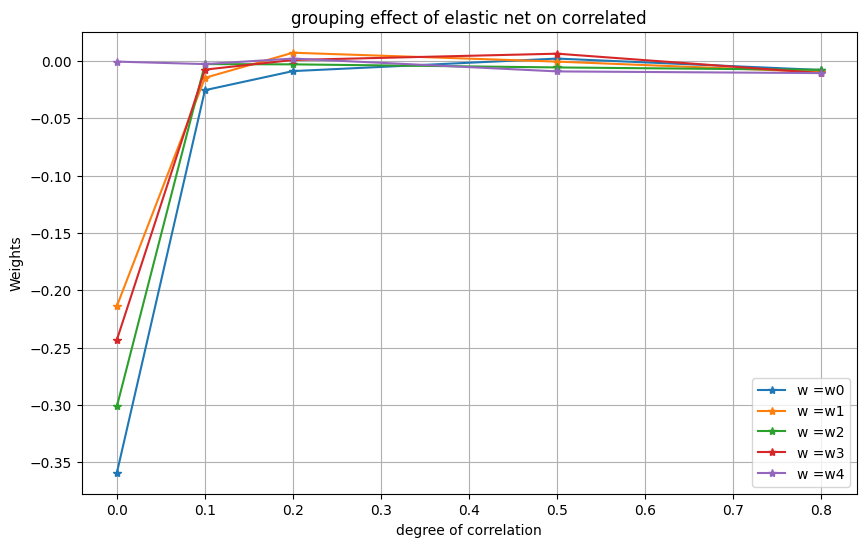

In [60]:
##X_CO computed in previous part gives correlated input data matrix
## to control degree of correlation lets use a new method to compute generater matrix
covariance = [0,0.1, 0.2, 0.5 , 0.8]
D = 5 ## no of features
M = 5
## weights initialized random
w = np.random.randn(D, 1)
## learning rate  (asked chat gpt what should it be can always improvise)
learningRate = 0.01
## no of iterations
Iterations = 1000
##Lamdas for regularization
lambda1 = 0.1 ##asked gpt for initial values
ratio = 0.5 ## can always tweek to control extend of lasso and ridge
##array to store weights
weights = np.zeros((D,len(covariance)))

for k,c in enumerate(covariance): ## k index of covariance
    ##generater matrix
    G = np.eye(D) + c*(np.ones((D,D)) - np.eye(D)) ## same as manual method
    X = generate_input_data(N,G,M)
    ##target matrix
    t = generate_target_matrix(X, w , sigma)
    ##for correlated input
    w = elastic_net_gradient(X, w, t, lambda1, ratio, Iterations, learningRate)
    weights[:,k] = w.flatten() ## each colum stores consecutive iterations
##plot weights against covariance  ## same as q11
plt.figure(figsize=(10, 6))
for i in range(w.shape[0]):
    plt.plot(covariance, weights[i,:], marker='*', label=f'w =w{i}') ## asked gemini
plt.xlabel('degree of correlation')
plt.ylabel('Weights')
plt.title('grouping effect of elastic net on correlated')
plt.grid(True)
plt.legend()



As seen in above plot as correlation among feautures increase weights slowly converge to zero 
This clearly demonstrated the grouping effect as the Elastic Net encourages grouping of correlated variables (i.e correlated features) tend to have similar coefficients rather than arbitrarily selecting one variable from each group so they have almost identical cofficients

Q13 : in linear binary classification the label asssosciated with each input in X has a binary value
given according to ti = sign(W^T * x + bias if any) we have to code this t out and then we add some gaussian noice to make it realistic

ref : https://numpy.org/doc/stable/reference/generated/numpy.where.html
idea of np.where => gemini


In [78]:
def classification_vector(input, weights,sigma):
    ##target vector same as one for linear regression just we have to 
    ## seperate it into binary labels [-1,1]
    t = generate_target_matrix(input, weights, sigma)
    ##classification vector
    t_binary = np.where(t > 0, 1, 0) ##whwer t>0 it replaces it with -1 else t = 1
    return t_binary
    

Q14: Binary cross entropy function is basically same as loss function which is difference between predicted labels and actual target labels.Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value.
ref : https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/

derivation of grad  = https://www.python-unleashed.com/post/derivation-of-the-binary-cross-entropy-loss-gradient




In [79]:
def binary_cross_entropy(input, weights,target):
    ##prediction
    p = np.dot(input, weights)
    ##for classification we are interested in predicted probalities not values
    ## convert to probability using sigmoid -- credit chat gpt
    pred = 1 / (1 + np.exp(-p))
    ## computation of gradient  derived using chain rule
    N = input.shape[0]
    error = target - pred
    grad =   np.dot(input.T,-error) / N ## however the loss function
    return grad 


Q15  editing code snippet for Q10 replacing functions defined for binary classification

In [86]:
def updateWeights(input, weights, target, alpha1, alpha2, iterations, learningRate):
    ##lets make cost function 
    costValues = []
    for i in range(iterations):  ## try to keep iteratations large so that converge well before
        pred = np.dot(input,weights)   ##assuming input is N X D and weigts D X 1
        ##chat gpt for pred for logLoss better to deviate it a little from 0 and 1
        epsi = 1e-15
        pred = np.clip(pred, epsi, 1 - epsi)
        ## log loss
        ## ref : https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/
        logLoss = -(target * np.log(pred) + (1 - target) * np.log(1 -pred))
        logLoss = np.mean(logLoss)
        ##L1 regularization
        lambda1 = alpha1 
        L1 = lambda1 * np.sum(np.abs(weights)) ## simply coded defination
        ###L2 regularization
        lambda2= alpha2 
        L2 = lambda2 * np.sum(np.square(weights))
        ##NET COST
        cost = logLoss + L1 + L2
        ##store cost
        costValues.append(cost)
        gradient = binary_cross_entropy(input, weights, target) + grad_L1(weights) + grad_L2(weights)
        ##update weight acc to basic gradient descent
        r = learningRate ## to be tuned
        weights = weights - r * gradient
        
        ##stopping criteria  credits gpt
        epsilon = 0.001  #3 to be tuned
        if i > 0 and np.abs(costValues[-1] - costValues[-2]) < epsilon:
            print(f"Converged after {i} iterations.")
            break
    return weights
    

In [84]:
def analysisClassification(sigma, Nvalues, alpha1, alpha2Values, iterations, learningRate,D, numRuns =5):
    ##analysis => plots => storing values
    avgnmrseValues = [] ## list of list to store nmrse for each N lambda 2 pair
    ## generate data
    M = 5 ## arbitary
    D = 2 ## no of features    
    ## weights initialized random
    w = np.random.randn(D, 1)
    
    for N in NValues: #iterate over sample size  ##i.efor i run
        avgnmrseN = [] #3 stores nmrse at given N averaged out over 5 run
        for alpha2 in (alpha2Values):  ## iterate over alpha
            nmrseValues = [] 
            for i in range(numRuns): ## 5 runs for each lambda N pair
                G = np.eye(M,D)  ##identity generator matrix of sample size
                ##input matrix
                X = generate_input_data(N,G, M)
        
                ##target matrix
                t = classification_vector(X, w , sigma)
                ##split data  partial credits gpt
                tRatio = 0.8 ##asked chat gpt for optimal value owing to bias - variance tradeoff
                train_size = int(tRatio * N) ##size of training data
                indices = np.random.permutation(N) ## random indices for training data  better training
                ##split indices in training and validation sets
                train_indices, val_indices = indices[:train_size], indices[train_size:]
                ## split input
                X_train, X_val = X[train_indices], X[val_indices]
                ##split target values
                t_train, t_val = t[train_indices], t[val_indices]
                
                ##training using gradient descent 
                ##update w acc to gradient descent
                w = updateWeights(X_train, w, t_train, alpha1, alpha2, iterations, learningRate) ##returns optimized weights
                ##now we have weights test these on valditatin data to which model would be exposed for first time
                ##i.e nmrse should be min 
                nmrse = nrmse(X_val, w, t_val)
                ##add nmrse after each run to list so that we can avg it out
                nmrseValues.append(nmrse)
            ##average out for given alpha at given N
            avgnmrse = np.mean(nmrseValues)
            avgnmrseN.append(avgnmrse)  ## at a given N variation with lambda 2
        ##make a array where ith row corresponds to nmrse for all alphas at ith N
        avgnmrseValues.append(avgnmrseN)
        ##  5 x 5 array
    ##we have list of avgValues for each sigma
    return avgnmrseValues
                

Converged after 23 iterations.
Converged after 19 iterations.
Converged after 285 iterations.
Converged after 626 iterations.
Converged after 75 iterations.


/tmp/ipykernel_55453/3110091277.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  nmrse = rmse/ran


Converged after 160 iterations.
Converged after 613 iterations.
Converged after 51 iterations.
Converged after 114 iterations.
Converged after 2 iterations.
Converged after 338 iterations.
Converged after 108 iterations.
Converged after 16 iterations.
Converged after 161 iterations.
Converged after 39 iterations.
Converged after 331 iterations.
Converged after 240 iterations.
Converged after 515 iterations.
Converged after 153 iterations.
Converged after 6 iterations.
Converged after 56 iterations.
Converged after 117 iterations.
Converged after 163 iterations.
Converged after 349 iterations.
Converged after 15 iterations.
Converged after 382 iterations.
Converged after 51 iterations.
Converged after 31 iterations.
Converged after 140 iterations.
Converged after 102 iterations.
Converged after 92 iterations.
Converged after 70 iterations.
Converged after 30 iterations.
Converged after 40 iterations.
Converged after 71 iterations.
Converged after 7 iterations.
Converged after 16 iterati

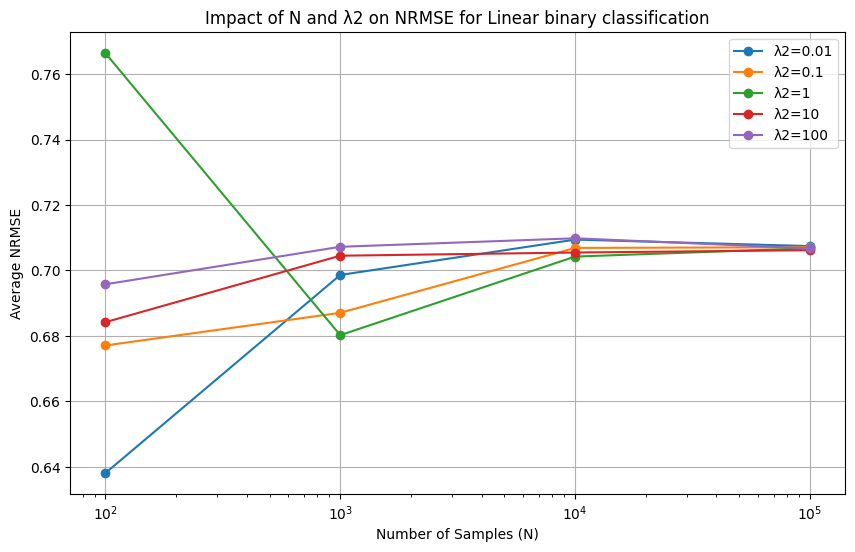

In [87]:
##sent different sample size
NValues = [10**n for n in range(1,6)]  # Noise variance
##optimal variance from 9th part
sigma  = 9
D = 2  ## no of features
## learning rate  (asked chat gpt what should it be can always improvise)
learning_rate = 0.01
## no of iterations
Iterations = 1000
##Lamdas for regularization
lambda1 = 0.1 ##arbitary effect not analysedd
lambda2Values = [0.01, 0.1 , 1, 10 ,100] 
# perform analysis
Values = analysisClassification(sigma, N,lambda1,lambda2Values, Iterations, learning_rate, D)

# credit to this plotting idea goes to gemini 
# basically iterate through every row of Values matrix each row corresponds to distribution
## -- against alpha2's for given N
plt.figure(figsize=(10, 6))
for i in range(len(lambda2Values)):
    plt.plot(NValues, [row[i] for row in Values], marker='o', label=f'λ2={lambda2Values[i]}') ## asked gemini
plt.xlabel('Number of Samples (N)')
plt.ylabel('Average NRMSE')
plt.title('Impact of N and λ2 on NRMSE for Linear binary classification')
plt.legend()
plt.grid(True)
## using log scale
plt.xscale('log')
plt.show()

same trends as linear classification observed  
high sample size effect of regularization diminishes becauses can work even with constrained weights
expected bias variance tradeoff , low lamdas and high lambdas high error due to overfitting and underfitting
again spikes at intermedite lambas observed for some reason